# 第41章: 拡散モデルの実装（発展編）- DDIMと高速サンプリング

## 📋 この章で学ぶこと

この章を終えると、以下ができるようになります：

- [ ] DDIMの理論を理解できる
- [ ] DDIMサンプリングを実装できる
- [ ] サンプリングステップ数と品質のトレードオフを理解できる
- [ ] 様々なノイズスケジュールを比較できる

## 🎯 前提知識

この章を学ぶには以下の知識が必要です：

- ✅ Notebook 37-38（拡散モデル理論）
- ✅ Notebook 39-40（U-NetとDDPM実装）

⏱️ **推定学習時間**: 150-180分  
📊 **難易度**: ★★★★☆（上級）  
🎓 **カテゴリ**: 実践

---

## 🌟 はじめに

DDPMは高品質な画像を生成できますが、サンプリングに1000ステップ必要という問題があります。

### 🤔 DDPMの課題

| 問題 | 影響 |
|------|------|
| 1000ステップのサンプリング | 生成に時間がかかる |
| 確率的サンプリング | 同じ初期ノイズでも毎回異なる結果 |

### 💡 DDIMの解決策

**DDIM (Denoising Diffusion Implicit Models)**:
- **決定論的サンプリング**: 同じ初期ノイズ → 同じ画像
- **高速サンプリング**: 50-100ステップで高品質な生成
- **訓練不要**: DDPMで訓練したモデルをそのまま使用

In [1]:
# ============================================================
# 環境設定
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.auto import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',
        'Yu Gothic', 'MS Gothic', 'Noto Sans CJK JP', 'IPAexGothic',
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"日本語フォント: {font_used}")

device = torch.device('cuda' if torch.cuda.is_available() else 
                      'mps' if torch.backends.mps.is_available() else 'cpu')

torch.manual_seed(42)
np.random.seed(42)

print(f"Device: {device}")
print("✅ ライブラリのインポート完了")

日本語フォント: Hiragino Sans
Device: mps
✅ ライブラリのインポート完了


---

## 1. U-NetとDDPMの準備（Notebook 40から）

In [2]:
# ============================================================
# U-Net定義（Notebook 39-40から）
# ============================================================

class SinusoidalPositionEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = t[:, None] * embeddings[None, :]
        embeddings = torch.cat([torch.sin(embeddings), torch.cos(embeddings)], dim=-1)
        return embeddings


class TimeConditionedConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim, num_groups=8):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(num_groups, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(num_groups, out_channels)
        self.activation = nn.SiLU()
        self.time_mlp = nn.Sequential(nn.SiLU(), nn.Linear(time_dim, out_channels))
        if in_channels != out_channels:
            self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.residual_conv = nn.Identity()
    
    def forward(self, x, t_emb):
        residual = self.residual_conv(x)
        x = self.activation(self.norm1(self.conv1(x)))
        t_emb = self.time_mlp(t_emb)[:, :, None, None]
        x = x + t_emb
        x = self.activation(self.norm2(self.conv2(x)))
        return x + residual


class Downsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
    def forward(self, x):
        return self.conv(x)


class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return self.conv(x)


class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, time_dim=128, 
                 base_channels=64, channel_mults=(1, 2, 4)):
        super().__init__()
        self.time_dim = time_dim
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbedding(time_dim),
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim),
        )
        self.init_conv = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1)
        self.down_blocks = nn.ModuleList()
        self.down_samples = nn.ModuleList()
        channels = [base_channels * m for m in channel_mults]
        in_ch = base_channels
        for i, out_ch in enumerate(channels):
            self.down_blocks.append(TimeConditionedConvBlock(in_ch, out_ch, time_dim))
            if i < len(channels) - 1:
                self.down_samples.append(Downsample(out_ch))
            in_ch = out_ch
        self.mid_block = TimeConditionedConvBlock(channels[-1], channels[-1], time_dim)
        self.up_samples = nn.ModuleList()
        self.up_blocks = nn.ModuleList()
        reversed_channels = list(reversed(channels))
        for i, out_ch in enumerate(reversed_channels):
            if i == 0:
                # 最初のブロック：ボトルネックからの入力のみ
                in_ch = reversed_channels[0]
            else:
                # 前のブロックの出力 + スキップ接続
                in_ch = reversed_channels[i-1] + channels[len(channels)-1-i]
            if i > 0:
                self.up_samples.append(Upsample(reversed_channels[i-1]))
            self.up_blocks.append(
                TimeConditionedConvBlock(in_ch, out_ch, time_dim)
            )
        self.final_conv = nn.Sequential(
            nn.GroupNorm(8, base_channels),
            nn.SiLU(),
            nn.Conv2d(base_channels, out_channels, kernel_size=3, padding=1),
        )
    
    def forward(self, x, t):
        t_emb = self.time_embed(t.float())
        x = self.init_conv(x)
        skip_connections = []
        for i, block in enumerate(self.down_blocks):
            x = block(x, t_emb)
            skip_connections.append(x)
            if i < len(self.down_samples):
                x = self.down_samples[i](x)
        x = self.mid_block(x, t_emb)
        for i, block in enumerate(self.up_blocks):
            if i > 0:
                x = self.up_samples[i-1](x)
                skip = skip_connections[-(i+1)]
                x = torch.cat([x, skip], dim=1)
            x = block(x, t_emb)
        return self.final_conv(x)

print("✅ U-Netを定義しました")

✅ U-Netを定義しました


---

## 2. DDIMの理論

### 📊 DDPMとDDIMの比較

**DDPM（確率的）**:
$$x_{t-1} = \mu_\theta(x_t, t) + \sigma_t \cdot z, \quad z \sim \mathcal{N}(0, I)$$

**DDIM（決定論的）**:
$$x_{t-1} = \sqrt{\bar\alpha_{t-1}} \cdot \hat{x}_0 + \sqrt{1 - \bar\alpha_{t-1}} \cdot \epsilon_\theta(x_t, t)$$

ここで、予測された $x_0$ は:
$$\hat{x}_0 = \frac{x_t - \sqrt{1 - \bar\alpha_t} \cdot \epsilon_\theta(x_t, t)}{\sqrt{\bar\alpha_t}}$$

### 💡 DDIMの利点

1. **任意のステップ数**: T=1000で訓練しても、50ステップでサンプリング可能
2. **決定論的**: 同じ初期ノイズ → 同じ出力（再現性）
3. **補間**: 潜在空間での意味のある補間が可能

In [3]:
# ============================================================
# DDIMサンプラーの実装
# ============================================================

class DDIMSampler:
    """
    DDIM (Denoising Diffusion Implicit Models) サンプラー
    
    DDPMで訓練したモデルを使って高速サンプリング
    """
    
    def __init__(self, model, T=1000, beta_start=1e-4, beta_end=0.02, device='cpu'):
        self.model = model
        self.T = T
        self.device = device
        
        # ノイズスケジュール
        self.betas = torch.linspace(beta_start, beta_end, T).to(device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
    
    def get_sampling_timesteps(self, num_steps):
        """
        サンプリングに使うタイムステップのサブセットを取得
        
        例: T=1000, num_steps=50 → [0, 20, 40, ..., 980]
        """
        step_size = self.T // num_steps
        timesteps = list(range(0, self.T, step_size))
        return timesteps[::-1]  # 逆順（T-1 から 0 へ）
    
    @torch.no_grad()
    def ddim_step(self, x_t, t, t_prev, eta=0.0):
        """
        DDIMの1ステップ
        
        Parameters:
        -----------
        x_t : Tensor
            現在のノイズ画像
        t : int
            現在のタイムステップ
        t_prev : int
            次のタイムステップ
        eta : float
            確率性の度合い（0=決定論的、1=DDPM相当）
        """
        alpha_bar_t = self.alpha_bars[t]
        alpha_bar_t_prev = self.alpha_bars[t_prev] if t_prev >= 0 else torch.tensor(1.0).to(self.device)
        
        # ノイズを予測
        t_tensor = torch.full((x_t.shape[0],), t, device=self.device, dtype=torch.long)
        noise_pred = self.model(x_t, t_tensor)
        
        # x_0 を予測
        x0_pred = (x_t - torch.sqrt(1 - alpha_bar_t) * noise_pred) / torch.sqrt(alpha_bar_t)
        x0_pred = torch.clamp(x0_pred, -1, 1)  # クリップ
        
        # 方向を計算
        sigma_t = eta * torch.sqrt((1 - alpha_bar_t_prev) / (1 - alpha_bar_t)) * \
                  torch.sqrt(1 - alpha_bar_t / alpha_bar_t_prev)
        
        # 次のステップを計算
        direction = torch.sqrt(1 - alpha_bar_t_prev - sigma_t**2) * noise_pred
        x_prev = torch.sqrt(alpha_bar_t_prev) * x0_pred + direction
        
        if eta > 0 and t_prev > 0:
            noise = torch.randn_like(x_t)
            x_prev = x_prev + sigma_t * noise
        
        return x_prev, x0_pred
    
    @torch.no_grad()
    def sample(self, shape, num_steps=50, eta=0.0, return_all_steps=False):
        """
        DDIMサンプリング
        
        Parameters:
        -----------
        shape : tuple
            生成画像のサイズ (B, C, H, W)
        num_steps : int
            サンプリングステップ数
        eta : float
            確率性パラメータ（0=決定論的）
        """
        timesteps = self.get_sampling_timesteps(num_steps)
        
        # ノイズから開始
        x = torch.randn(shape, device=self.device)
        
        if return_all_steps:
            all_steps = [x.cpu()]
            all_x0_preds = []
        
        for i, t in enumerate(tqdm(timesteps, desc=f'DDIM Sampling ({num_steps} steps)')):
            t_prev = timesteps[i + 1] if i < len(timesteps) - 1 else -1
            x, x0_pred = self.ddim_step(x, t, t_prev, eta)
            
            if return_all_steps:
                all_steps.append(x.cpu())
                all_x0_preds.append(x0_pred.cpu())
        
        if return_all_steps:
            return x, all_steps, all_x0_preds
        return x

print("✅ DDIMサンプラーを定義しました")

✅ DDIMサンプラーを定義しました


---

## 3. モデルの訓練

In [4]:
# ============================================================
# データセット準備
# ============================================================

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# サブセット
subset_size = 10000
indices = np.random.choice(len(train_dataset), subset_size, replace=False)
train_subset = Subset(train_dataset, indices)

batch_size = 128
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, drop_last=True)

print(f"データセットサイズ: {len(train_subset):,}")

データセットサイズ: 10,000


In [5]:
# ============================================================
# 訓練（DDPMと同じ方法）
# ============================================================

# モデル
model = SimpleUNet(
    in_channels=1, out_channels=1,
    time_dim=128, base_channels=64, channel_mults=(1, 2, 4)
).to(device)

# ノイズスケジュール
T = 1000
betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

# 訓練関数
def compute_loss(model, x_0, alpha_bars, T, device):
    batch_size = x_0.shape[0]
    t = torch.randint(0, T, (batch_size,), device=device)
    noise = torch.randn_like(x_0)
    alpha_bar_t = alpha_bars[t].view(-1, 1, 1, 1)
    x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise
    noise_pred = model(x_t, t)
    return F.mse_loss(noise_pred, noise)

# オプティマイザ
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

# 訓練
num_epochs = 20
losses = []

print("訓練開始...")
for epoch in range(num_epochs):
    model.train()
    epoch_losses = []
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for batch, _ in pbar:
        batch = batch.to(device)
        loss = compute_loss(model, batch, alpha_bars, T, device)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        epoch_losses.append(loss.item())
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = np.mean(epoch_losses)
    losses.extend(epoch_losses)
    print(f"  Epoch {epoch+1}: Loss = {avg_loss:.4f}")

print("✅ 訓練完了")

訓練開始...


Epoch 1/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 1: Loss = 0.1594


Epoch 2/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 2: Loss = 0.0503


Epoch 3/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 3: Loss = 0.0402


Epoch 4/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 4: Loss = 0.0370


Epoch 5/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 5: Loss = 0.0354


Epoch 6/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 6: Loss = 0.0319


Epoch 7/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 7: Loss = 0.0314


Epoch 8/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 8: Loss = 0.0314


Epoch 9/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 9: Loss = 0.0308


Epoch 10/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 10: Loss = 0.0287


Epoch 11/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 11: Loss = 0.0295


Epoch 12/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 12: Loss = 0.0292


Epoch 13/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 13: Loss = 0.0282


Epoch 14/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 14: Loss = 0.0277


Epoch 15/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 15: Loss = 0.0264


Epoch 16/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 16: Loss = 0.0271


Epoch 17/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 17: Loss = 0.0264


Epoch 18/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 18: Loss = 0.0263


Epoch 19/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 19: Loss = 0.0253


Epoch 20/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 20: Loss = 0.0256
✅ 訓練完了


---

## 4. DDIMサンプリングの比較

In [6]:
# ============================================================
# DDIMサンプラーを作成
# ============================================================

model.eval()
ddim = DDIMSampler(model, T=1000, device=device)

print("DDIMサンプラーを作成しました")

DDIMサンプラーを作成しました


  10 steps: 0.52秒
  25 steps: 0.16秒
  50 steps: 0.27秒
  100 steps: 0.55秒
  250 steps: 1.47秒
  500 steps: 2.69秒


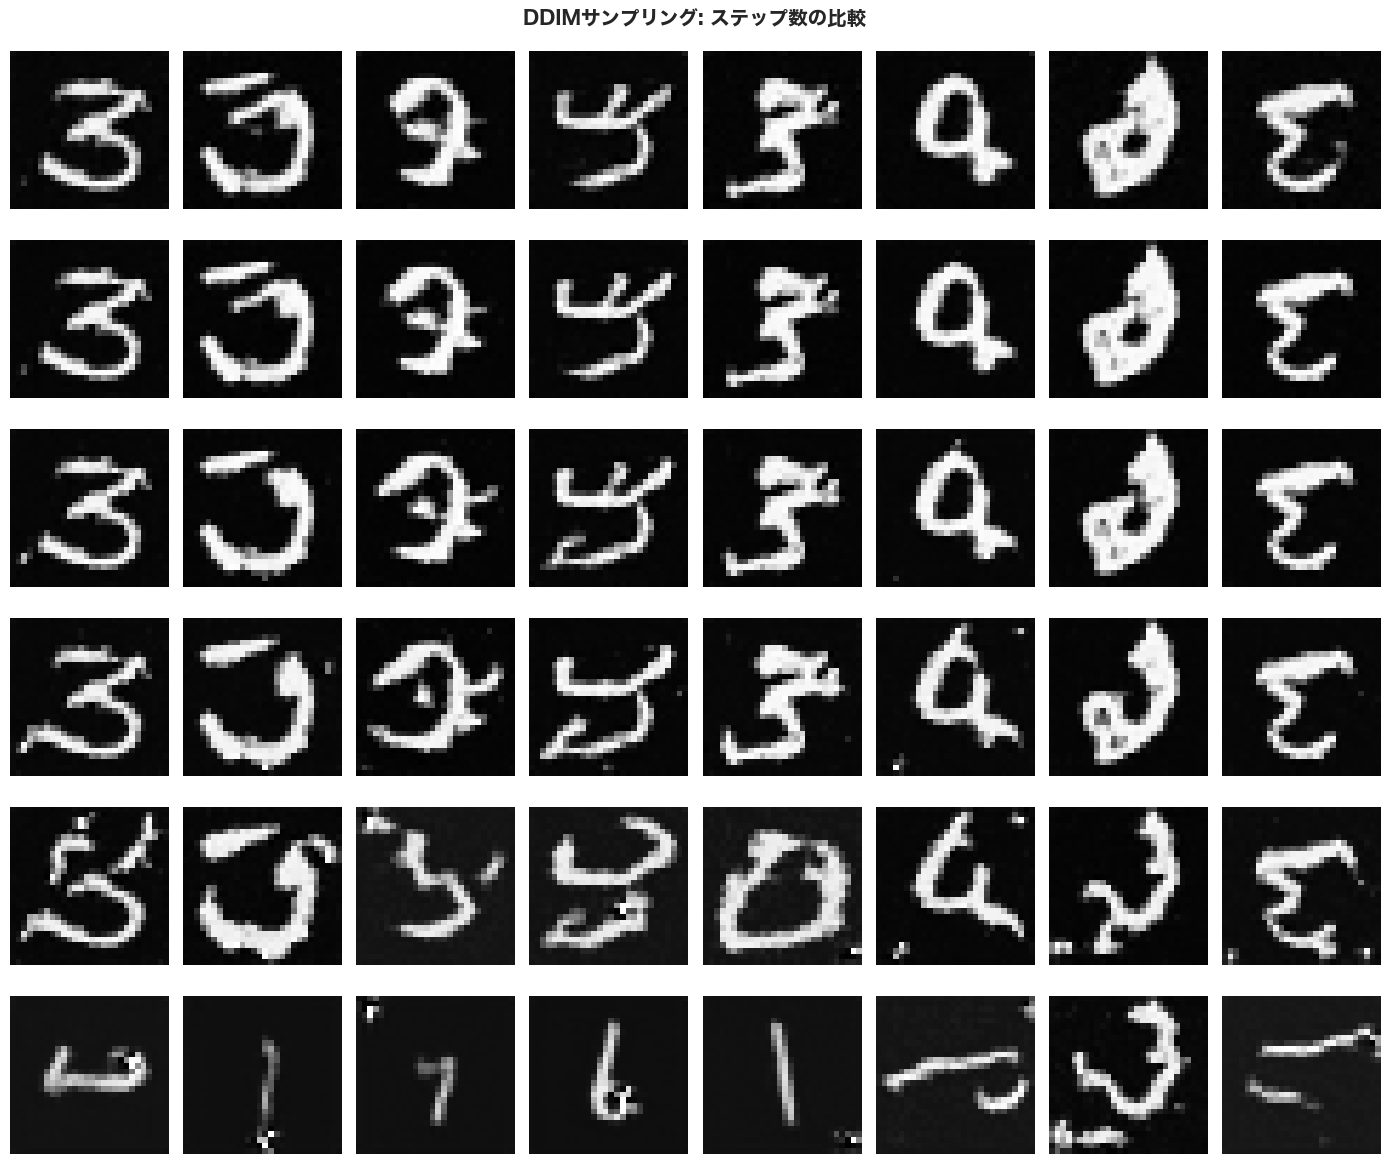


💡 観察:
  - 少ないステップでも認識可能な画像が生成される
  - 50-100ステップで良好な品質が得られる
  - 同じ初期ノイズ → 同じ画像（決定論的）


In [7]:
# ============================================================
# 異なるステップ数での比較
# ============================================================

# 同じ初期ノイズを使用
torch.manual_seed(42)
initial_noise = torch.randn(8, 1, 28, 28, device=device)

step_counts = [10, 25, 50, 100, 250, 500]
results = {}
times = {}

for num_steps in step_counts:
    torch.manual_seed(42)  # 再現性のため
    x = initial_noise.clone()
    
    start_time = time.time()
    timesteps = ddim.get_sampling_timesteps(num_steps)
    
    for i, t in enumerate(timesteps):
        t_prev = timesteps[i + 1] if i < len(timesteps) - 1 else -1
        x, _ = ddim.ddim_step(x, t, t_prev, eta=0.0)
    
    elapsed = time.time() - start_time
    results[num_steps] = x.cpu()
    times[num_steps] = elapsed
    print(f"  {num_steps} steps: {elapsed:.2f}秒")

# 結果を可視化
fig, axes = plt.subplots(len(step_counts), 8, figsize=(14, len(step_counts) * 2))

for row, num_steps in enumerate(step_counts):
    for col in range(8):
        img = results[num_steps][col].squeeze().numpy()
        img = np.clip(img * 0.5 + 0.5, 0, 1)
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].axis('off')
    axes[row, 0].set_ylabel(f'{num_steps} steps\n({times[num_steps]:.1f}s)', fontsize=10)

plt.suptitle('DDIMサンプリング: ステップ数の比較', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 観察:")
print("  - 少ないステップでも認識可能な画像が生成される")
print("  - 50-100ステップで良好な品質が得られる")
print("  - 同じ初期ノイズ → 同じ画像（決定論的）")

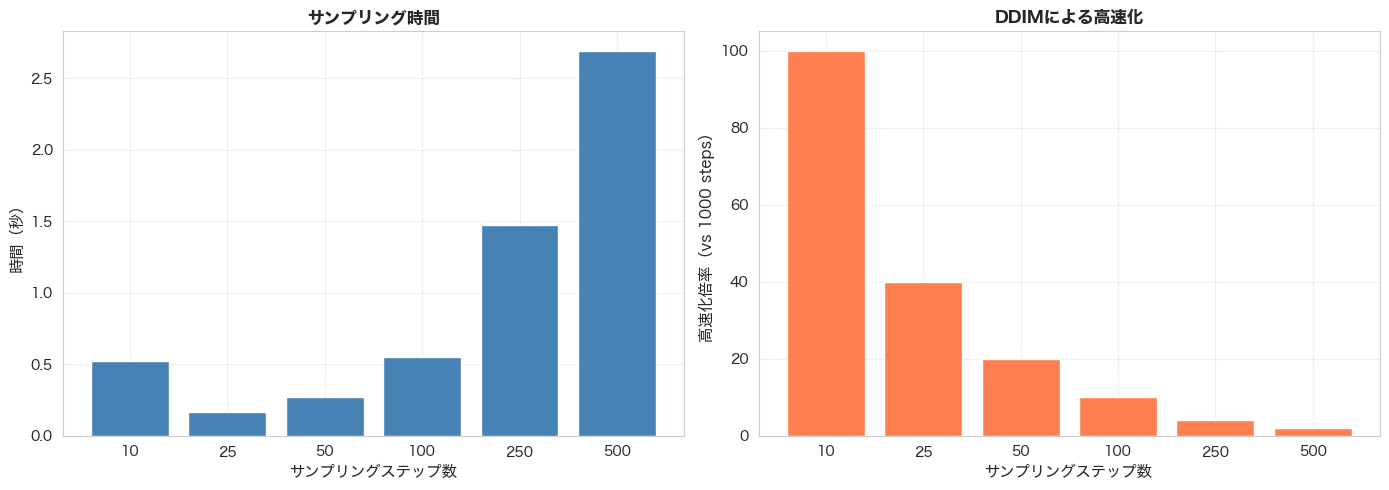


📊 高速化:
  10 steps: 100.0x 高速化
  25 steps: 40.0x 高速化
  50 steps: 20.0x 高速化
  100 steps: 10.0x 高速化
  250 steps: 4.0x 高速化
  500 steps: 2.0x 高速化


In [8]:
# ============================================================
# 速度と品質のトレードオフ
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# サンプリング時間
ax = axes[0]
ax.bar([str(s) for s in step_counts], [times[s] for s in step_counts], color='steelblue')
ax.set_xlabel('サンプリングステップ数', fontsize=11)
ax.set_ylabel('時間（秒）', fontsize=11)
ax.set_title('サンプリング時間', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# スピードアップ（1000ステップとの比較）
ax = axes[1]
speedups = [1000/s for s in step_counts]
ax.bar([str(s) for s in step_counts], speedups, color='coral')
ax.set_xlabel('サンプリングステップ数', fontsize=11)
ax.set_ylabel('高速化倍率（vs 1000 steps）', fontsize=11)
ax.set_title('DDIMによる高速化', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 高速化:")
for s in step_counts:
    print(f"  {s} steps: {1000/s:.1f}x 高速化")

---

## 5. 確率性パラメータ η の効果

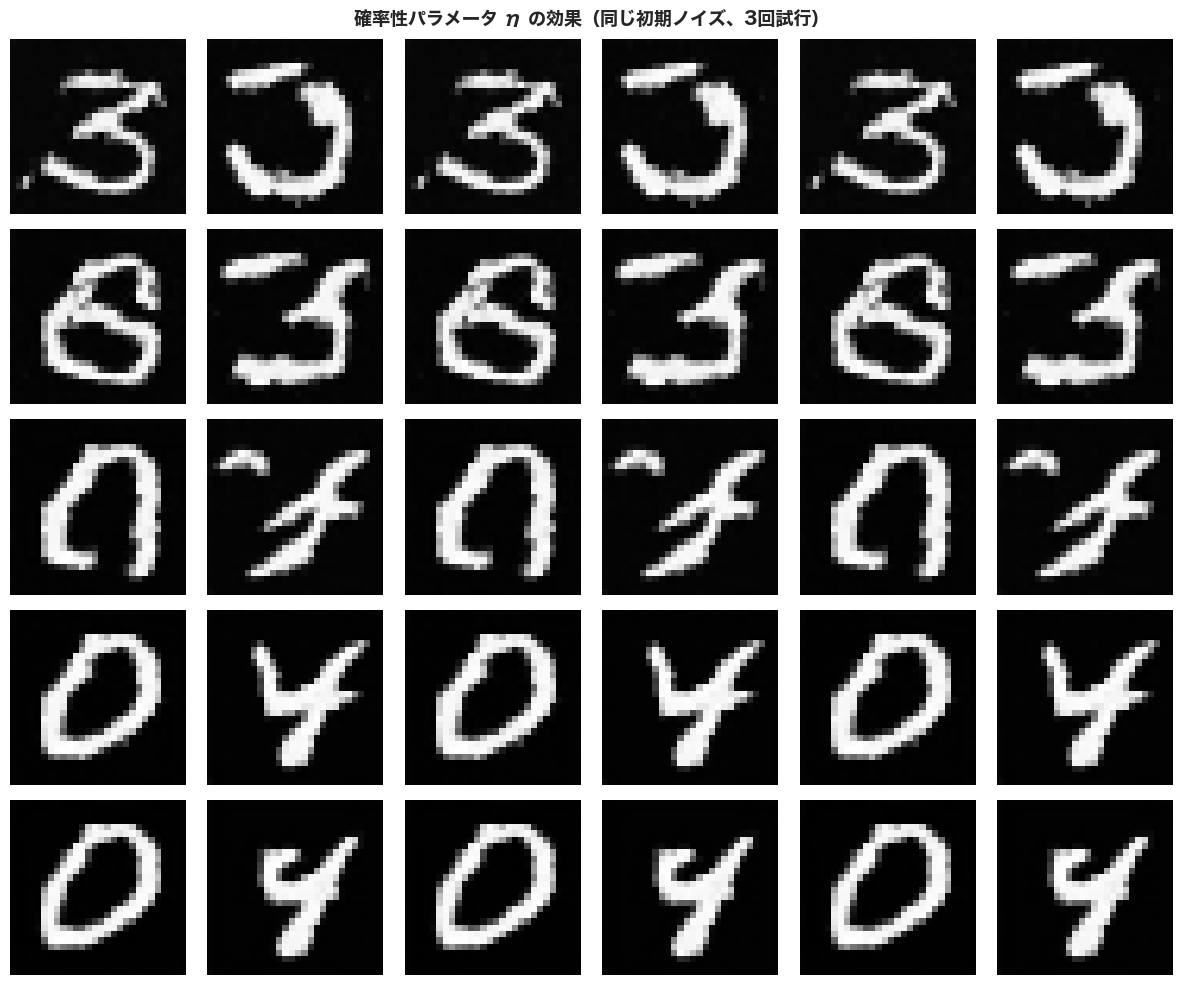

💡 観察:
  - η = 0: 毎回同じ結果（決定論的）
  - η > 0: 結果にばらつきが生じる（確率的）
  - η = 1: DDPMと同様の確率性


In [9]:
# ============================================================
# η（確率性）の効果
# ============================================================

# η = 0: 完全に決定論的（DDIM）
# η = 1: 確率的（DDPMに近い）

eta_values = [0.0, 0.25, 0.5, 0.75, 1.0]
num_steps = 50

# 各ηで同じ初期ノイズから3回サンプリング
fig, axes = plt.subplots(len(eta_values), 6, figsize=(12, len(eta_values) * 2))

for row, eta in enumerate(eta_values):
    for trial in range(3):
        # 同じ初期ノイズ
        torch.manual_seed(42)
        x = torch.randn(2, 1, 28, 28, device=device)
        
        timesteps = ddim.get_sampling_timesteps(num_steps)
        for i, t in enumerate(timesteps):
            t_prev = timesteps[i + 1] if i < len(timesteps) - 1 else -1
            x, _ = ddim.ddim_step(x, t, t_prev, eta=eta)
        
        for k in range(2):
            img = x[k].squeeze().cpu().numpy()
            img = np.clip(img * 0.5 + 0.5, 0, 1)
            axes[row, trial * 2 + k].imshow(img, cmap='gray')
            axes[row, trial * 2 + k].axis('off')
    
    axes[row, 0].set_ylabel(f'η = {eta}', fontsize=10)

plt.suptitle('確率性パラメータ η の効果（同じ初期ノイズ、3回試行）', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 観察:")
print("  - η = 0: 毎回同じ結果（決定論的）")
print("  - η > 0: 結果にばらつきが生じる（確率的）")
print("  - η = 1: DDPMと同様の確率性")

---

## 6. 潜在空間での補間

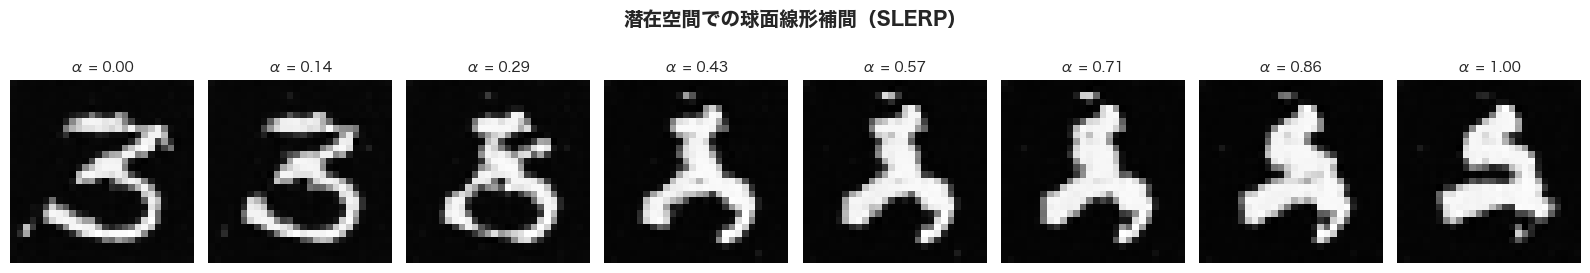

💡 DDIMの決定論的な性質により、潜在空間での意味のある補間が可能


In [10]:
# ============================================================
# 潜在空間での補間
# ============================================================

def slerp(z1, z2, alpha):
    """球面線形補間"""
    z1_flat = z1.flatten()
    z2_flat = z2.flatten()
    
    # コサイン類似度から角度を計算
    dot = (z1_flat * z2_flat).sum() / (z1_flat.norm() * z2_flat.norm())
    dot = torch.clamp(dot, -1, 1)
    omega = torch.acos(dot)
    
    if omega.abs() < 1e-10:
        return (1 - alpha) * z1 + alpha * z2
    
    so = torch.sin(omega)
    return (torch.sin((1 - alpha) * omega) / so) * z1 + (torch.sin(alpha * omega) / so) * z2

# 2つの初期ノイズを生成
torch.manual_seed(42)
z1 = torch.randn(1, 1, 28, 28, device=device)
torch.manual_seed(123)
z2 = torch.randn(1, 1, 28, 28, device=device)

# 補間
num_interp = 8
alphas = torch.linspace(0, 1, num_interp)

interpolated = []
for alpha in alphas:
    z_interp = slerp(z1, z2, alpha.item())
    
    # DDIMでサンプリング
    x = z_interp.clone()
    timesteps = ddim.get_sampling_timesteps(50)
    for i, t in enumerate(timesteps):
        t_prev = timesteps[i + 1] if i < len(timesteps) - 1 else -1
        x, _ = ddim.ddim_step(x, t, t_prev, eta=0.0)
    
    interpolated.append(x.squeeze().cpu().numpy())

# 可視化
fig, axes = plt.subplots(1, num_interp, figsize=(16, 3))
for i, (ax, img) in enumerate(zip(axes, interpolated)):
    img = np.clip(img * 0.5 + 0.5, 0, 1)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'α = {alphas[i]:.2f}', fontsize=10)
    ax.axis('off')

plt.suptitle('潜在空間での球面線形補間（SLERP）', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 DDIMの決定論的な性質により、潜在空間での意味のある補間が可能")

---

## 7. ノイズスケジュールの比較

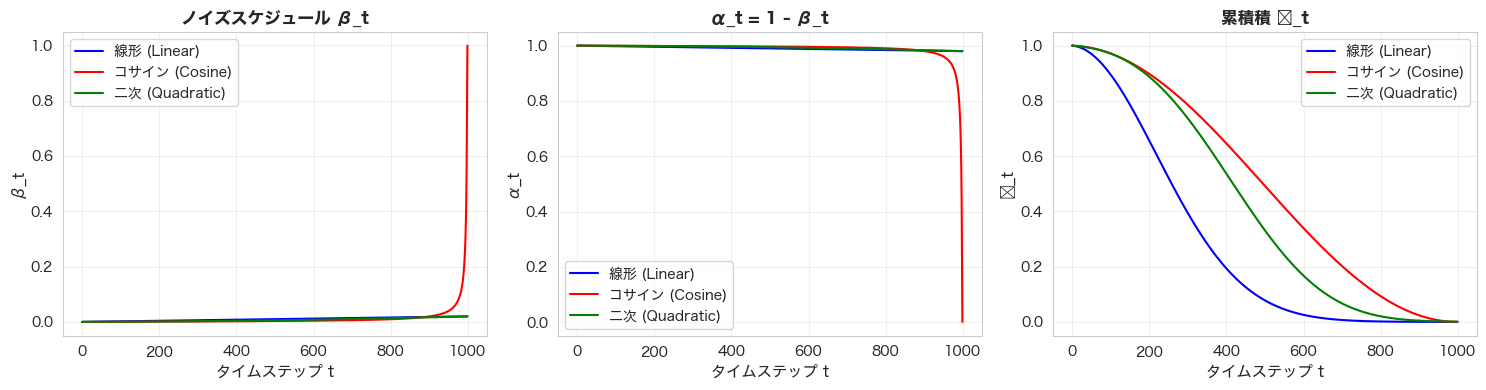

💡 コサインスケジュールの利点:
  - 序盤でのノイズ追加が緩やか
  - より均一な情報損失
  - 高解像度画像で特に効果的


In [11]:
# ============================================================
# 異なるノイズスケジュールの比較
# ============================================================

T = 1000

def linear_schedule(T, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, T)

def cosine_schedule(T, s=0.008):
    """Improved Denoising Diffusion Probabilistic Models (Nichol & Dhariwal, 2021)"""
    t = torch.linspace(0, T, T + 1)
    f_t = torch.cos(((t / T) + s) / (1 + s) * np.pi / 2) ** 2
    alpha_bars = f_t / f_t[0]
    betas = 1 - alpha_bars[1:] / alpha_bars[:-1]
    return torch.clamp(betas, 0, 0.999)

def quadratic_schedule(T, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start**0.5, beta_end**0.5, T) ** 2

# スケジュールを計算
schedules = {
    '線形 (Linear)': linear_schedule(T),
    'コサイン (Cosine)': cosine_schedule(T),
    '二次 (Quadratic)': quadratic_schedule(T),
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors = ['blue', 'red', 'green']

for ax_idx, (ax, plot_type) in enumerate(zip(axes, ['betas', 'alphas', 'alpha_bars'])):
    for (name, betas), color in zip(schedules.items(), colors):
        alphas = 1 - betas
        alpha_bars = torch.cumprod(alphas, dim=0)
        
        if plot_type == 'betas':
            ax.plot(betas.numpy(), label=name, color=color)
            ax.set_ylabel('β_t', fontsize=11)
            ax.set_title('ノイズスケジュール β_t', fontsize=12, fontweight='bold')
        elif plot_type == 'alphas':
            ax.plot(alphas.numpy(), label=name, color=color)
            ax.set_ylabel('α_t', fontsize=11)
            ax.set_title('α_t = 1 - β_t', fontsize=12, fontweight='bold')
        else:
            ax.plot(alpha_bars.numpy(), label=name, color=color)
            ax.set_ylabel('ᾱ_t', fontsize=11)
            ax.set_title('累積積 ᾱ_t', fontsize=12, fontweight='bold')
    
    ax.set_xlabel('タイムステップ t', fontsize=11)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 コサインスケジュールの利点:")
print("  - 序盤でのノイズ追加が緩やか")
print("  - より均一な情報損失")
print("  - 高解像度画像で特に効果的")

---

## まとめ

### 🎯 このノートブックで学んだこと

**DDIMサンプリング**
- ✓ 決定論的サンプリング（η = 0）
- ✓ 高速サンプリング（50-100ステップ）
- ✓ 潜在空間での補間

**パラメータの効果**
- ✓ ステップ数と品質のトレードオフ
- ✓ 確率性パラメータ η
- ✓ ノイズスケジュールの比較

### 📊 DDPMとDDIMの比較

| 特性 | DDPM | DDIM |
|------|------|------|
| サンプリング | 確率的 | 決定論的（η=0） |
| ステップ数 | T（例: 1000） | 任意（例: 50） |
| 再現性 | なし | あり |
| 補間 | 困難 | 可能 |
| 訓練 | 必要 | DDPM訓練済みモデルを使用 |

### 📊 推奨設定

| 用途 | ステップ数 | η |
|------|-----------|---|
| 高速プレビュー | 25-50 | 0 |
| バランス | 50-100 | 0 |
| 高品質 | 100-250 | 0 |
| 多様性が必要 | 50-100 | 0.5-1.0 |

---

## 🎓 自己評価クイズ

### Q1: DDIMがDDPMより高速な理由は？

<details>
<summary>💡 答えを見る</summary>

**答え**:
- DDIMは非マルコフ過程を使用
- 任意のタイムステップをスキップ可能
- 例: t=1000 → t=980 → t=960... と20ステップ飛ばし
- DDPMは各ステップが前のステップに依存（マルコフ過程）

</details>

---

### Q2: η = 0 と η = 1 の違いは？

<details>
<summary>💡 答えを見る</summary>

**答え**:
- **η = 0**: 完全に決定論的
  - 同じ初期ノイズ → 同じ出力
  - 補間が可能
- **η = 1**: DDPMと同じ確率性
  - 同じ初期ノイズでも異なる出力
  - より多様な生成

</details>

---

### Q3: コサインスケジュールの利点は？

<details>
<summary>💡 答えを見る</summary>

**答え**:
- 序盤（t が小さい）でのノイズ追加が緩やか
- 画像の詳細が長く保持される
- 高解像度画像で特に効果的
- 全体的により均一な情報損失

</details>

---

### ✅ 学習チェックリスト

- [ ] DDIMサンプリングを実装できる
- [ ] ステップ数と品質のトレードオフを説明できる
- [ ] η パラメータの効果を理解している
- [ ] 潜在空間での補間ができる

---

**次のステップ**: Notebook 42で、**条件付き生成（Classifier-Free Guidance）**を学びます！

特定のクラス（数字）を指定して画像を生成する方法を実装します。